In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import sklearn 
import datetime as dt
from datetime import timedelta 
from datetime import date
import pandas_datareader.data as web
%matplotlib inline

Performing quantitative analysis on a growth stock in the technology sector. Here, we'll be taking a look at Shopify, an e-commerce company and how its price has changed over time since its IPO. SHOP, listed on NYSE as well as TSX as (SHOP.TO), had IPO'd on May 21, 2015. 

In [22]:
style.use('ggplot')
# In this stock's case, the stock IPO'd in 2015
start = dt.datetime(2015,5,21)
# latest close date 
latest = date.today()
# retrieve data from Yahoo finance for the given dates
# DataReader is able to parse dates and indexes this column for us.
# otherwise, it'll be necessary to add parse_dates and index_col if reading a csv file.
df = web.DataReader('SHOP','yahoo',start,latest)
# datareader indexes date for us
print (df.tail(6))

                   High          Low         Open        Close   Volume  \
Date                                                                      
2020-07-27   977.460022   935.140015   947.570007   976.390015  2689900   
2020-07-28  1014.905029   975.169983  1007.090027   985.000000  3847400   
2020-07-29  1107.920044  1038.000000  1107.380005  1053.589966  6492300   
2020-07-30  1062.130005  1003.005005  1048.300049  1048.839966  2783900   
2020-07-31  1067.677002  1012.109985  1065.000000  1024.000000  2332500   
2020-08-03  1089.250000  1028.959961  1032.000000  1083.050049  2631810   

              Adj Close  
Date                     
2020-07-27   976.390015  
2020-07-28   985.000000  
2020-07-29  1053.589966  
2020-07-30  1048.839966  
2020-07-31  1024.000000  
2020-08-03  1083.050049  


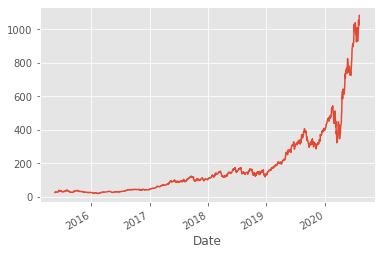

In [23]:
df['Adj Close'].plot()
# plt.show() 

Look at that beautiful curve! 
Since its IPO, SHOP has experienced explosive growth and recently, surpassed RBC on the TSX as the largest publicly listed company. From 17 to just shy of 1100 per share, a 64.7x fold increase since its IPO. 
Alright, let's dive in and do some technical analysis. 
Moving averages are an arithmetic mean of a certain number of data points over a given period of time. 50, 100 and 200 are the most common time periods used for analysis. Its common practice for many technical traders to use these averages to aid in choosing where to enter or exit a position, which then causes these levels to act as strong support or resistance.

Source: Investopedia.com
Note: I don't own any Shopify shares (although I wish I did!)

In [31]:
# Create column for Simple Moving average ('sma') for 100 days
# setting min_periods to 0 which will fill the values in 100d-sma column with close value instead of a NaN
df['100d-sma'] =  df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail(100)

,High,Low,Open,Close,Volume,Adj Close,100d-sma
Date,,,,,,,
2020-03-12,403.570007,366.100006,371.000000,377.779999,4419400,377.779999,403.135600
2020-03-13,406.420013,363.010010,404.000000,390.899994,3314400,390.899994,403.901200
2020-03-16,362.000000,321.500000,339.000000,322.290009,4179900,322.290009,403.926800
2020-03-17,358.000000,307.670013,330.019989,355.089996,4240800,355.089996,404.480800
2020-03-18,358.556000,305.299988,326.339996,336.829987,3522400,336.829987,404.877700
...,...,...,...,...,...,...,...
2020-07-28,1014.905029,975.169983,1007.090027,985.000000,3847400,985.000000,695.532602
2020-07-29,1107.920044,1038.000000,1107.380005,1053.589966,6492300,1053.589966,701.347801
2020-07-30,1062.130005,1003.005005,1048.300049,1048.839966,2783900,1048.839966,707.653001


We can plot multiple plots into one plot by using subplot, and get the adjusted closing value, the 100 day moving average and trading volume on the same plot. 

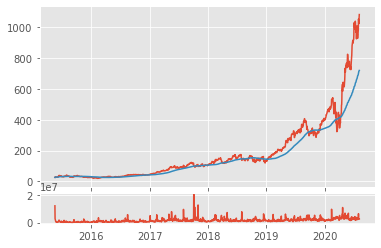

In [34]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100d-sma'])
ax2.plot(df.index, df['Volume'])

plt.show()